O3 농도 예측 모델의 학습 및 모델 예측 테스트 코드

VER: 
    
    v5.2

SETUP:

    In[NOx, VOC, 'VOC*NOx', 'NH3', 'PM25']
    Out[pred. O3]

STRUCTURE:

    CMAQ U-Net (w/o Conditional)

    model = build_model(
        ..., 
        hidden_size=[128, 96],
        hidden_depth=5,
        ...,
        in_filters=10,
        ...
    )

PARAMETER:

    EPOCH = 1000
    Lr = 1e-3
    test_split = 0.4

In [1]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-02-28 17:47:44.783885: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 17:47:44.815647: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-28 17:47:44.815685: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-28 17:47:44.815706: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 17:47:44.822185: I tensorflow/core/platform/cpu_feature_g

# Training

In [2]:
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/dataset_for_o3_v5.1.csv')

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data = ctrl_data[:, :17*5]
label_path_2013 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013'
label_path = []
for i in range(1, 120): 
    label_path.append(os.path.join(label_path_2013, '1.00', f'ACONC.{i}'))
label_data = []
for path in label_path:
    with nc.Dataset(path) as f:
        label_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
label_data = np.array(label_data).reshape(len(label_data), 82, 67, 1)

In [3]:
from src.model.cmaqnet_unet import build_model

model_path = '/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (50%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, y_train, y_test = train_test_split(emis_data, label_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        out_channel=1,
        hidden_size=[128, 96],
        hidden_depth=4,
        in_filters=20,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    '''    
        model = build_model(
        ctrl_dim=17*5,
        out_channel=1,
        hidden_size=[128, 96],
        hidden_depth=5,
        in_filters=10,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    '''
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanAbsoluteError(),
    )
    
# define callback
def scheduler(epoch, lr):
    # if epoch <= 1000: return 2.5e-3
    if epoch <= 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-{epoch:02d}-{val_loss:.4f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' 16min '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-02-28 17:47:47.288973: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18763 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-02-28 17:47:47.290699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 18763 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-02-28 17:47:47.292262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 18763 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-02-28 17:47:47.293793: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 18694 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-02-28 17:48:08.827641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-28 17:48:08.847159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-28 17:48:08.858048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-28 17:48:08.881774: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-02-28 17:48:11.850302: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0aff168cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-28 17:48:11.850332: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-28 17:48:11.850337: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-28 17:48:11.85034

3/3 [==============================] - ETA: 0s - loss: 0.1954 INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-01-0.0356/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-01-0.0356/assets


3/3 [==============================] - 38s 6s/step - loss: 0.1954 - val_loss: 0.0356 - lr: 0.0010
Epoch 2/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0755INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-02-0.0310/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-02-0.0310/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0750 - val_loss: 0.0310 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 0.0462INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-03-0.0246/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-03-0.0246/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0462 - val_loss: 0.0246 - lr: 0.0010
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 0.0304INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-04-0.0223/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-04-0.0223/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0304 - val_loss: 0.0223 - lr: 0.0010
Epoch 5/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0247 - val_loss: 0.0317 - lr: 0.0010
Epoch 6/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0197 - val_loss: 0.0423 - lr: 0.0010
Epoch 7/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0183 - val_loss: 0.0404 - lr: 0.0010
Epoch 8/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0175 - val_loss: 0.0459 - lr: 0.0010
Epoch 9/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0112 - val_loss: 0.0404 - lr: 0.0010
Epoch 10/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0111 - val_loss: 0.0440 - lr: 0.0010
Epoch 11/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0074 - val_loss: 0.0342 - lr: 0.0010
Epoch 12/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0070 - val_loss: 0.0306 - lr: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-16-0.0223/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0050 - val_loss: 0.0223 - lr: 0.0010
Epoch 17/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0054 - val_loss: 0.0240 - lr: 0.0010
Epoch 18/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0049INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-18-0.0174/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-18-0.0174/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0050 - val_loss: 0.0174 - lr: 0.0010
Epoch 19/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0053 - val_loss: 0.0182 - lr: 0.0010
Epoch 20/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0052INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-20-0.0150/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-20-0.0150/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0053 - val_loss: 0.0150 - lr: 0.0010
Epoch 21/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0048 - val_loss: 0.0160 - lr: 0.0010
Epoch 22/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0038 - val_loss: 0.0151 - lr: 0.0010
Epoch 23/1000
3/3 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-23-0.0125/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-23-0.0125/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0036 - val_loss: 0.0125 - lr: 0.0010
Epoch 24/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0045 - val_loss: 0.0126 - lr: 0.0010
Epoch 25/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0038INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-25-0.0122/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-25-0.0122/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0039 - val_loss: 0.0122 - lr: 0.0010
Epoch 26/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0039INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-26-0.0100/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-26-0.0100/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0041 - val_loss: 0.0100 - lr: 0.0010
Epoch 27/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0038 - val_loss: 0.0110 - lr: 0.0010
Epoch 28/1000
3/3 [==============================] - ETA: 0s - loss: 0.0038INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-28-0.0090/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-28-0.0090/assets


3/3 [==============================] - 7s 4s/step - loss: 0.0038 - val_loss: 0.0090 - lr: 0.0010
Epoch 29/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0041 - val_loss: 0.0103 - lr: 0.0010
Epoch 30/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-30-0.0078/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-30-0.0078/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0039 - val_loss: 0.0078 - lr: 0.0010
Epoch 31/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0043INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-31-0.0067/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-31-0.0067/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0045 - val_loss: 0.0067 - lr: 0.0010
Epoch 32/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0040 - val_loss: 0.0085 - lr: 0.0010
Epoch 33/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-33-0.0066/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-33-0.0066/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0038 - val_loss: 0.0066 - lr: 0.0010
Epoch 34/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0053 - val_loss: 0.0081 - lr: 0.0010
Epoch 35/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-35-0.0050/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-35-0.0050/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0035 - val_loss: 0.0050 - lr: 0.0010
Epoch 36/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0032 - val_loss: 0.0061 - lr: 0.0010
Epoch 37/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0030 - val_loss: 0.0051 - lr: 0.0010
Epoch 38/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0031INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-38-0.0046/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-38-0.0046/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0040 - val_loss: 0.0046 - lr: 0.0010
Epoch 39/1000
3/3 [==============================] - 0s 178ms/step - loss: 0.0034 - val_loss: 0.0050 - lr: 0.0010
Epoch 40/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0028INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-40-0.0044/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-40-0.0044/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0037 - val_loss: 0.0044 - lr: 0.0010
Epoch 41/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0029INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-41-0.0044/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-41-0.0044/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0030 - val_loss: 0.0044 - lr: 0.0010
Epoch 42/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0038 - val_loss: 0.0048 - lr: 0.0010
Epoch 43/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0034 - val_loss: 0.0049 - lr: 0.0010
Epoch 44/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0032 - val_loss: 0.0054 - lr: 0.0010
Epoch 45/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0030 - val_loss: 0.0048 - lr: 0.0010
Epoch 46/1000
3/3 [==============================] - 0s 179ms/step - loss: 0.0027 - val_loss: 0.0044 - lr: 0.0010
Epoch 47/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0030 - val_loss: 0.0058 - lr: 0.0010
Epoch 48/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0028 - val_loss: 0.0047 - lr: 0.0010
Epoch 49/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0028INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-49-0.0040/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0029 - val_loss: 0.0040 - lr: 0.0010
Epoch 50/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0031 - val_loss: 0.0052 - lr: 0.0010
Epoch 51/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0028 - val_loss: 0.0051 - lr: 0.0010
Epoch 52/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0028 - val_loss: 0.0050 - lr: 0.0010
Epoch 53/1000
3/3 [==============================] - 0s 175ms/step - loss: 0.0025 - val_loss: 0.0056 - lr: 0.0010
Epoch 54/1000
3/3 [==============================] - 0s 178ms/step - loss: 0.0027 - val_loss: 0.0050 - lr: 0.0010
Epoch 55/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0040 - val_loss: 0.0052 - lr: 0.0010
Epoch 56/1000
3/3 [==============================] - 0s 177ms/step - loss: 0.0027 - val_loss: 0.0073 - lr: 0.0010
Epoch 57/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0029 - val_loss: 0.0059 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-60-0.0034/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0029 - val_loss: 0.0034 - lr: 0.0010
Epoch 61/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0037 - val_loss: 0.0056 - lr: 0.0010
Epoch 62/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0028 - val_loss: 0.0052 - lr: 0.0010
Epoch 63/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0029 - val_loss: 0.0047 - lr: 0.0010
Epoch 64/1000
3/3 [==============================] - 1s 221ms/step - loss: 0.0036 - val_loss: 0.0074 - lr: 0.0010
Epoch 65/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0030 - val_loss: 0.0074 - lr: 0.0010
Epoch 66/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0022 - val_loss: 0.0068 - lr: 0.0010
Epoch 67/1000
3/3 [==============================] - 1s 251ms/step - loss: 0.0022 - val_loss: 0.0062 - lr: 0.0010
Epoch 68/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0022 - val_loss: 0.0061 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-131-0.0034/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0014 - val_loss: 0.0034 - lr: 0.0010
Epoch 132/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0014 - val_loss: 0.0041 - lr: 0.0010
Epoch 133/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0013 - val_loss: 0.0036 - lr: 0.0010
Epoch 134/1000
3/3 [==============================] - ETA: 0s - loss: 0.0013INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-134-0.0032/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-134-0.0032/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0013 - val_loss: 0.0032 - lr: 0.0010
Epoch 135/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0014INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-135-0.0027/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-135-0.0027/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0014 - val_loss: 0.0027 - lr: 0.0010
Epoch 136/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0017 - val_loss: 0.0028 - lr: 0.0010
Epoch 137/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0017 - val_loss: 0.0042 - lr: 0.0010
Epoch 138/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0018 - val_loss: 0.0049 - lr: 0.0010
Epoch 139/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0018 - val_loss: 0.0036 - lr: 0.0010
Epoch 140/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0017 - val_loss: 0.0029 - lr: 0.0010
Epoch 141/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0020 - val_loss: 0.0046 - lr: 0.0010
Epoch 142/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0021 - val_loss: 0.0052 - lr: 0.0010
Epoch 143/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0021INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-143-0.0023/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0020 - val_loss: 0.0023 - lr: 0.0010
Epoch 144/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0020 - val_loss: 0.0026 - lr: 0.0010
Epoch 145/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0018 - val_loss: 0.0035 - lr: 0.0010
Epoch 146/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0016 - val_loss: 0.0036 - lr: 0.0010
Epoch 147/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0014 - val_loss: 0.0032 - lr: 0.0010
Epoch 148/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0016 - val_loss: 0.0024 - lr: 0.0010
Epoch 149/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0019 - val_loss: 0.0038 - lr: 0.0010
Epoch 150/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0020 - val_loss: 0.0037 - lr: 0.0010
Epoch 151/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0018INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-151-0.0019/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0018 - val_loss: 0.0019 - lr: 0.0010
Epoch 152/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0017 - val_loss: 0.0024 - lr: 0.0010
Epoch 153/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0017 - val_loss: 0.0036 - lr: 0.0010
Epoch 154/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0014 - val_loss: 0.0037 - lr: 0.0010
Epoch 155/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0015 - val_loss: 0.0031 - lr: 0.0010
Epoch 156/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0014 - val_loss: 0.0025 - lr: 0.0010
Epoch 157/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0019 - val_loss: 0.0050 - lr: 0.0010
Epoch 158/1000
3/3 [==============================] - 1s 226ms/step - loss: 0.0020 - val_loss: 0.0024 - lr: 0.0010
Epoch 159/1000
3/3 [==============================] - ETA: 0s - loss: 0.0015INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-159-0.0017/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0015 - val_loss: 0.0017 - lr: 0.0010
Epoch 160/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0019 - val_loss: 0.0024 - lr: 0.0010
Epoch 161/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0012 - val_loss: 0.0028 - lr: 0.0010
Epoch 162/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0013 - val_loss: 0.0025 - lr: 0.0010
Epoch 163/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0013 - val_loss: 0.0027 - lr: 0.0010
Epoch 164/1000
3/3 [==============================] - ETA: 0s - loss: 0.0014INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-164-0.0015/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-164-0.0015/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0014 - val_loss: 0.0015 - lr: 0.0010
Epoch 165/1000
3/3 [==============================] - 1s 236ms/step - loss: 0.0017 - val_loss: 0.0021 - lr: 0.0010
Epoch 166/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0018 - val_loss: 0.0018 - lr: 0.0010
Epoch 167/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0016 - val_loss: 0.0016 - lr: 0.0010
Epoch 168/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0015 - val_loss: 0.0025 - lr: 0.0010
Epoch 169/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0016 - val_loss: 0.0034 - lr: 0.0010
Epoch 170/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0018 - val_loss: 0.0044 - lr: 0.0010
Epoch 171/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0018 - val_loss: 0.0035 - lr: 0.0010
Epoch 172/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0015 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-175-0.0013/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0016 - val_loss: 0.0013 - lr: 0.0010
Epoch 176/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0014 - val_loss: 0.0015 - lr: 0.0010
Epoch 177/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0013 - val_loss: 0.0016 - lr: 0.0010
Epoch 178/1000
3/3 [==============================] - 0s 177ms/step - loss: 0.0013 - val_loss: 0.0029 - lr: 0.0010
Epoch 179/1000
3/3 [==============================] - 1s 227ms/step - loss: 0.0014 - val_loss: 0.0025 - lr: 0.0010
Epoch 180/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0015 - val_loss: 0.0017 - lr: 0.0010
Epoch 181/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0016 - val_loss: 0.0031 - lr: 0.0010
Epoch 182/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0014 - val_loss: 0.0038 - lr: 0.0010
Epoch 183/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0017 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-219-0.0011/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0011 - val_loss: 0.0011 - lr: 0.0010
Epoch 220/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0011 - val_loss: 0.0019 - lr: 0.0010
Epoch 221/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0010 - val_loss: 0.0016 - lr: 0.0010
Epoch 222/1000
3/3 [==============================] - 0s 196ms/step - loss: 9.6589e-04 - val_loss: 0.0022 - lr: 0.0010
Epoch 223/1000
3/3 [==============================] - 0s 180ms/step - loss: 0.0011 - val_loss: 0.0021 - lr: 0.0010
Epoch 224/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0010 - val_loss: 0.0019 - lr: 0.0010
Epoch 225/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0010 - val_loss: 0.0022 - lr: 0.0010
Epoch 226/1000
3/3 [==============================] - 0s 204ms/step - loss: 9.2752e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 227/1000
3/3 [==============================] - 0s 225ms/step - loss: 9.9622e-04 - v

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-228-0.0009/assets


3/3 [==============================] - 7s 3s/step - loss: 0.0010 - val_loss: 8.8275e-04 - lr: 0.0010
Epoch 229/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0010 - val_loss: 0.0012 - lr: 0.0010
Epoch 230/1000
3/3 [==============================] - 1s 238ms/step - loss: 0.0011 - val_loss: 9.1757e-04 - lr: 0.0010
Epoch 231/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0014 - val_loss: 0.0017 - lr: 0.0010
Epoch 232/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0015 - val_loss: 0.0016 - lr: 0.0010
Epoch 233/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0014 - val_loss: 0.0013 - lr: 0.0010
Epoch 234/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0012 - val_loss: 0.0016 - lr: 0.0010
Epoch 235/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0012 - val_loss: 0.0011 - lr: 0.0010
Epoch 236/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0010 - val_l

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-311-0.0008/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0011 - val_loss: 7.9777e-04 - lr: 0.0010
Epoch 312/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0011 - val_loss: 8.0390e-04 - lr: 0.0010
Epoch 313/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0011 - val_loss: 0.0020 - lr: 0.0010
Epoch 314/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0011 - val_loss: 9.1891e-04 - lr: 0.0010
Epoch 315/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0010 - val_loss: 0.0011 - lr: 0.0010
Epoch 316/1000
3/3 [==============================] - 0s 191ms/step - loss: 8.8357e-04 - val_loss: 9.2012e-04 - lr: 0.0010
Epoch 317/1000
3/3 [==============================] - 1s 244ms/step - loss: 8.4529e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 318/1000
3/3 [==============================] - 0s 192ms/step - loss: 9.1543e-04 - val_loss: 9.1714e-04 - lr: 0.0010
Epoch 319/1000
3/3 [==============================] - 0s 182ms/ste

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-334-0.0008/assets


3/3 [==============================] - 8s 4s/step - loss: 8.7894e-04 - val_loss: 7.8051e-04 - lr: 0.0010
Epoch 335/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0011 - val_loss: 9.2208e-04 - lr: 0.0010
Epoch 336/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0010 - val_loss: 0.0013 - lr: 0.0010
Epoch 337/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0010 - val_loss: 0.0010 - lr: 0.0010
Epoch 338/1000
3/3 [==============================] - 0s 197ms/step - loss: 9.4389e-04 - val_loss: 9.3098e-04 - lr: 0.0010
Epoch 339/1000
3/3 [==============================] - 0s 203ms/step - loss: 8.9428e-04 - val_loss: 9.3454e-04 - lr: 0.0010
Epoch 340/1000
3/3 [==============================] - 0s 209ms/step - loss: 7.6153e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 341/1000
3/3 [==============================] - 0s 198ms/step - loss: 7.1643e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 342/1000
3/3 [==============================] - 0s 191ms

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-346-0.0008/assets


3/3 [==============================] - 7s 3s/step - loss: 9.5998e-04 - val_loss: 7.5237e-04 - lr: 0.0010
Epoch 347/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0010 - val_loss: 8.0927e-04 - lr: 0.0010
Epoch 348/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0010 - val_loss: 0.0013 - lr: 0.0010
Epoch 349/1000
3/3 [==============================] - 0s 186ms/step - loss: 8.3819e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 350/1000
3/3 [==============================] - 0s 186ms/step - loss: 9.0589e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 351/1000
3/3 [==============================] - 0s 169ms/step - loss: 9.0816e-04 - val_loss: 8.5164e-04 - lr: 0.0010
Epoch 352/1000
3/3 [==============================] - 0s 178ms/step - loss: 8.7744e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 353/1000
3/3 [==============================] - 0s 186ms/step - loss: 9.3732e-04 - val_loss: 8.6989e-04 - lr: 0.0010
Epoch 354/1000
3/3 [==============================] - 0s 1

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-360-0.0007/assets


3/3 [==============================] - 8s 4s/step - loss: 9.3408e-04 - val_loss: 7.1062e-04 - lr: 0.0010
Epoch 361/1000
3/3 [==============================] - 1s 225ms/step - loss: 9.4452e-04 - val_loss: 7.6335e-04 - lr: 0.0010
Epoch 362/1000
3/3 [==============================] - 0s 205ms/step - loss: 9.2960e-04 - val_loss: 0.0013 - lr: 0.0010
Epoch 363/1000
3/3 [==============================] - 0s 188ms/step - loss: 8.2526e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 364/1000
3/3 [==============================] - ETA: 0s - loss: 8.9586e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-364-0.0007/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-364-0.0007/assets


3/3 [==============================] - 8s 4s/step - loss: 8.9586e-04 - val_loss: 6.9228e-04 - lr: 0.0010
Epoch 365/1000
3/3 [==============================] - 0s 199ms/step - loss: 9.2722e-04 - val_loss: 7.2418e-04 - lr: 0.0010
Epoch 366/1000
3/3 [==============================] - 0s 220ms/step - loss: 8.0852e-04 - val_loss: 0.0014 - lr: 0.0010
Epoch 367/1000
3/3 [==============================] - 0s 197ms/step - loss: 9.3570e-04 - val_loss: 0.0017 - lr: 0.0010
Epoch 368/1000
3/3 [==============================] - 0s 193ms/step - loss: 8.9690e-04 - val_loss: 9.7621e-04 - lr: 0.0010
Epoch 369/1000
3/3 [==============================] - 0s 223ms/step - loss: 8.8548e-04 - val_loss: 9.6066e-04 - lr: 0.0010
Epoch 370/1000
3/3 [==============================] - 1s 225ms/step - loss: 0.0011 - val_loss: 0.0016 - lr: 0.0010
Epoch 371/1000
3/3 [==============================] - 0s 212ms/step - loss: 9.8232e-04 - val_loss: 0.0015 - lr: 0.0010
Epoch 372/1000
3/3 [==============================] - 

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-376-0.0006/assets


3/3 [==============================] - 8s 4s/step - loss: 9.1031e-04 - val_loss: 6.2766e-04 - lr: 0.0010
Epoch 377/1000
3/3 [==============================] - 0s 219ms/step - loss: 8.8947e-04 - val_loss: 8.0007e-04 - lr: 0.0010
Epoch 378/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0011 - val_loss: 9.9258e-04 - lr: 0.0010
Epoch 379/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0010 - val_loss: 9.1235e-04 - lr: 0.0010
Epoch 380/1000
3/3 [==============================] - 0s 212ms/step - loss: 9.7713e-04 - val_loss: 8.3969e-04 - lr: 0.0010
Epoch 381/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0011 - val_loss: 0.0012 - lr: 0.0010
Epoch 382/1000
3/3 [==============================] - 1s 235ms/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0010
Epoch 383/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0014 - val_loss: 0.0011 - lr: 0.0010
Epoch 384/1000
3/3 [==============================] - 0s 211ms/ste

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-410-0.0006/assets


3/3 [==============================] - 7s 4s/step - loss: 5.4724e-04 - val_loss: 5.7069e-04 - lr: 0.0010
Epoch 411/1000
3/3 [==============================] - 0s 203ms/step - loss: 5.2604e-04 - val_loss: 7.6574e-04 - lr: 0.0010
Epoch 412/1000
3/3 [==============================] - 0s 207ms/step - loss: 4.7938e-04 - val_loss: 6.6828e-04 - lr: 0.0010
Epoch 413/1000
3/3 [==============================] - 0s 200ms/step - loss: 4.9641e-04 - val_loss: 6.5864e-04 - lr: 0.0010
Epoch 414/1000
3/3 [==============================] - 0s 184ms/step - loss: 5.8767e-04 - val_loss: 7.6645e-04 - lr: 0.0010
Epoch 415/1000
3/3 [==============================] - 0s 201ms/step - loss: 5.6835e-04 - val_loss: 6.0817e-04 - lr: 0.0010
Epoch 416/1000
3/3 [==============================] - 2s 898ms/step - loss: 5.4835e-04 - val_loss: 7.5016e-04 - lr: 0.0010
Epoch 417/1000
3/3 [==============================] - 1s 234ms/step - loss: 6.0501e-04 - val_loss: 7.0800e-04 - lr: 0.0010
Epoch 418/1000
2/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-418-0.0006/assets


3/3 [==============================] - 7s 4s/step - loss: 5.5074e-04 - val_loss: 5.6974e-04 - lr: 0.0010
Epoch 419/1000
3/3 [==============================] - 0s 208ms/step - loss: 6.8907e-04 - val_loss: 9.4225e-04 - lr: 0.0010
Epoch 420/1000
3/3 [==============================] - 0s 194ms/step - loss: 8.1264e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 421/1000
3/3 [==============================] - 0s 208ms/step - loss: 8.6069e-04 - val_loss: 6.0712e-04 - lr: 0.0010
Epoch 422/1000
3/3 [==============================] - 0s 206ms/step - loss: 8.0136e-04 - val_loss: 8.6359e-04 - lr: 0.0010
Epoch 423/1000
3/3 [==============================] - 1s 238ms/step - loss: 9.0225e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 424/1000
3/3 [==============================] - 0s 190ms/step - loss: 7.0246e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 425/1000
3/3 [==============================] - 0s 221ms/step - loss: 9.3094e-04 - val_loss: 7.8605e-04 - lr: 0.0010
Epoch 426/1000
3/3 [==========================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-454-0.0006/assets


3/3 [==============================] - 8s 4s/step - loss: 5.3986e-04 - val_loss: 5.5018e-04 - lr: 0.0010
Epoch 455/1000
3/3 [==============================] - 0s 186ms/step - loss: 6.2417e-04 - val_loss: 8.7769e-04 - lr: 0.0010
Epoch 456/1000
3/3 [==============================] - 0s 196ms/step - loss: 8.9596e-04 - val_loss: 8.3887e-04 - lr: 0.0010
Epoch 457/1000
3/3 [==============================] - 0s 207ms/step - loss: 7.4038e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 458/1000
3/3 [==============================] - 0s 211ms/step - loss: 9.8862e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 459/1000
3/3 [==============================] - 0s 189ms/step - loss: 7.8955e-04 - val_loss: 6.4952e-04 - lr: 0.0010
Epoch 460/1000
3/3 [==============================] - 0s 197ms/step - loss: 6.3960e-04 - val_loss: 7.0336e-04 - lr: 0.0010
Epoch 461/1000
3/3 [==============================] - 0s 203ms/step - loss: 6.3942e-04 - val_loss: 6.9713e-04 - lr: 0.0010
Epoch 462/1000
3/3 [======================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-508-0.0005/assets


3/3 [==============================] - 8s 4s/step - loss: 6.6543e-04 - val_loss: 4.5816e-04 - lr: 0.0010
Epoch 509/1000
3/3 [==============================] - 0s 184ms/step - loss: 7.3637e-04 - val_loss: 5.7805e-04 - lr: 0.0010
Epoch 510/1000
3/3 [==============================] - 0s 210ms/step - loss: 7.7619e-04 - val_loss: 0.0012 - lr: 0.0010
Epoch 511/1000
3/3 [==============================] - 0s 189ms/step - loss: 8.4321e-04 - val_loss: 7.1883e-04 - lr: 0.0010
Epoch 512/1000
3/3 [==============================] - 0s 188ms/step - loss: 6.0221e-04 - val_loss: 6.0249e-04 - lr: 0.0010
Epoch 513/1000
3/3 [==============================] - 0s 198ms/step - loss: 5.8258e-04 - val_loss: 6.0108e-04 - lr: 0.0010
Epoch 514/1000
3/3 [==============================] - 0s 189ms/step - loss: 6.9085e-04 - val_loss: 6.6869e-04 - lr: 0.0010
Epoch 515/1000
3/3 [==============================] - 0s 192ms/step - loss: 7.0197e-04 - val_loss: 0.0016 - lr: 0.0010
Epoch 516/1000
3/3 [======================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-590-0.0004/assets


3/3 [==============================] - 7s 4s/step - loss: 7.0253e-04 - val_loss: 4.1855e-04 - lr: 0.0010
Epoch 591/1000
3/3 [==============================] - 0s 199ms/step - loss: 4.9764e-04 - val_loss: 5.1886e-04 - lr: 0.0010
Epoch 592/1000
3/3 [==============================] - 0s 197ms/step - loss: 5.7464e-04 - val_loss: 9.5088e-04 - lr: 0.0010
Epoch 593/1000
3/3 [==============================] - 0s 182ms/step - loss: 6.4699e-04 - val_loss: 4.8919e-04 - lr: 0.0010
Epoch 594/1000
3/3 [==============================] - 0s 204ms/step - loss: 7.9924e-04 - val_loss: 6.6571e-04 - lr: 0.0010
Epoch 595/1000
3/3 [==============================] - 0s 204ms/step - loss: 7.2005e-04 - val_loss: 0.0010 - lr: 0.0010
Epoch 596/1000
3/3 [==============================] - 0s 196ms/step - loss: 6.8878e-04 - val_loss: 7.4718e-04 - lr: 0.0010
Epoch 597/1000
3/3 [==============================] - 0s 201ms/step - loss: 6.2636e-04 - val_loss: 7.0043e-04 - lr: 0.0010
Epoch 598/1000
3/3 [==================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-628-0.0004/assets


3/3 [==============================] - 8s 4s/step - loss: 5.6533e-04 - val_loss: 3.9558e-04 - lr: 0.0010
Epoch 629/1000
3/3 [==============================] - 0s 186ms/step - loss: 5.0735e-04 - val_loss: 6.1401e-04 - lr: 0.0010
Epoch 630/1000
3/3 [==============================] - 0s 180ms/step - loss: 5.7085e-04 - val_loss: 0.0011 - lr: 0.0010
Epoch 631/1000
3/3 [==============================] - 0s 210ms/step - loss: 6.5110e-04 - val_loss: 5.1981e-04 - lr: 0.0010
Epoch 632/1000
3/3 [==============================] - 0s 198ms/step - loss: 6.8627e-04 - val_loss: 7.9267e-04 - lr: 0.0010
Epoch 633/1000
3/3 [==============================] - 0s 177ms/step - loss: 7.9539e-04 - val_loss: 9.3686e-04 - lr: 0.0010
Epoch 634/1000
3/3 [==============================] - 0s 226ms/step - loss: 6.7509e-04 - val_loss: 7.8790e-04 - lr: 0.0010
Epoch 635/1000
3/3 [==============================] - 0s 214ms/step - loss: 5.6492e-04 - val_loss: 5.1966e-04 - lr: 0.0010
Epoch 636/1000
3/3 [==================

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-653-0.0004/assets


3/3 [==============================] - 8s 4s/step - loss: 6.7193e-04 - val_loss: 3.5859e-04 - lr: 0.0010
Epoch 654/1000
3/3 [==============================] - 0s 214ms/step - loss: 5.0486e-04 - val_loss: 4.5166e-04 - lr: 0.0010
Epoch 655/1000
3/3 [==============================] - 1s 237ms/step - loss: 5.5078e-04 - val_loss: 6.0195e-04 - lr: 0.0010
Epoch 656/1000
3/3 [==============================] - 0s 221ms/step - loss: 4.8546e-04 - val_loss: 6.3766e-04 - lr: 0.0010
Epoch 657/1000
3/3 [==============================] - 0s 216ms/step - loss: 4.7071e-04 - val_loss: 5.0460e-04 - lr: 0.0010
Epoch 658/1000
3/3 [==============================] - 0s 208ms/step - loss: 5.1945e-04 - val_loss: 7.3645e-04 - lr: 0.0010
Epoch 659/1000
3/3 [==============================] - 0s 199ms/step - loss: 5.6605e-04 - val_loss: 6.9018e-04 - lr: 0.0010
Epoch 660/1000
3/3 [==============================] - 0s 220ms/step - loss: 5.4599e-04 - val_loss: 7.1437e-04 - lr: 0.0010
Epoch 661/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-793-0.0003/assets


3/3 [==============================] - 8s 4s/step - loss: 3.4280e-04 - val_loss: 3.0890e-04 - lr: 0.0010
Epoch 794/1000
3/3 [==============================] - 0s 212ms/step - loss: 3.4734e-04 - val_loss: 5.5043e-04 - lr: 0.0010
Epoch 795/1000
3/3 [==============================] - 0s 213ms/step - loss: 4.2307e-04 - val_loss: 3.7549e-04 - lr: 0.0010
Epoch 796/1000
3/3 [==============================] - 0s 177ms/step - loss: 4.9064e-04 - val_loss: 5.1138e-04 - lr: 0.0010
Epoch 797/1000
3/3 [==============================] - 0s 212ms/step - loss: 5.9165e-04 - val_loss: 5.8745e-04 - lr: 0.0010
Epoch 798/1000
3/3 [==============================] - 0s 215ms/step - loss: 4.2465e-04 - val_loss: 4.6012e-04 - lr: 0.0010
Epoch 799/1000
3/3 [==============================] - 0s 187ms/step - loss: 5.0701e-04 - val_loss: 5.7373e-04 - lr: 0.0010
Epoch 800/1000
3/3 [==============================] - 0s 202ms/step - loss: 8.2331e-04 - val_loss: 7.8025e-04 - lr: 0.0010
Epoch 801/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-898-0.0003/assets


3/3 [==============================] - 7s 4s/step - loss: 5.3375e-04 - val_loss: 3.0397e-04 - lr: 0.0010
Epoch 899/1000
3/3 [==============================] - 0s 211ms/step - loss: 5.0962e-04 - val_loss: 8.5683e-04 - lr: 0.0010
Epoch 900/1000
3/3 [==============================] - 0s 213ms/step - loss: 8.0896e-04 - val_loss: 5.0064e-04 - lr: 0.0010
Epoch 901/1000
3/3 [==============================] - 0s 201ms/step - loss: 5.2502e-04 - val_loss: 6.4429e-04 - lr: 0.0010
Epoch 902/1000
3/3 [==============================] - 0s 187ms/step - loss: 5.3141e-04 - val_loss: 3.5959e-04 - lr: 0.0010
Epoch 903/1000
3/3 [==============================] - 0s 208ms/step - loss: 5.4322e-04 - val_loss: 5.3651e-04 - lr: 0.0010
Epoch 904/1000
3/3 [==============================] - 0s 199ms/step - loss: 6.8000e-04 - val_loss: 9.2753e-04 - lr: 0.0010
Epoch 905/1000
3/3 [==============================] - 0s 202ms/step - loss: 5.9604e-04 - val_loss: 6.6848e-04 - lr: 0.0010
Epoch 906/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-936-0.0003/assets


3/3 [==============================] - 9s 4s/step - loss: 3.5882e-04 - val_loss: 2.9056e-04 - lr: 0.0010
Epoch 937/1000
3/3 [==============================] - 1s 238ms/step - loss: 3.1940e-04 - val_loss: 3.0012e-04 - lr: 0.0010
Epoch 938/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.5949e-04INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-938-0.0003/assets


INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)-938-0.0003/assets


3/3 [==============================] - 8s 4s/step - loss: 2.7144e-04 - val_loss: 2.7010e-04 - lr: 0.0010
Epoch 939/1000
3/3 [==============================] - 0s 215ms/step - loss: 3.0596e-04 - val_loss: 4.8715e-04 - lr: 0.0010
Epoch 940/1000
3/3 [==============================] - 0s 200ms/step - loss: 3.3534e-04 - val_loss: 4.0366e-04 - lr: 0.0010
Epoch 941/1000
3/3 [==============================] - 0s 196ms/step - loss: 3.4949e-04 - val_loss: 4.1649e-04 - lr: 0.0010
Epoch 942/1000
3/3 [==============================] - 0s 189ms/step - loss: 4.1539e-04 - val_loss: 3.1146e-04 - lr: 0.0010
Epoch 943/1000
3/3 [==============================] - 0s 205ms/step - loss: 4.0704e-04 - val_loss: 4.1705e-04 - lr: 0.0010
Epoch 944/1000
3/3 [==============================] - 0s 217ms/step - loss: 3.7127e-04 - val_loss: 6.1988e-04 - lr: 0.0010
Epoch 945/1000
3/3 [==============================] - 1s 238ms/step - loss: 4.6515e-04 - val_loss: 6.1532e-04 - lr: 0.0010
Epoch 946/1000
3/3 [==============

INFO:tensorflow:Assets written to: /home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)/assets


' 16min '

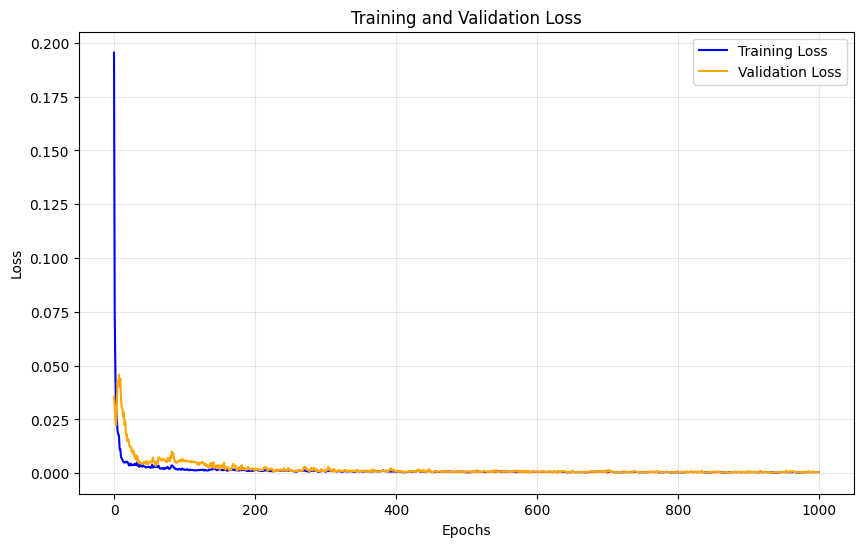

In [4]:
plot_loss(history)

# Prediction & Performance

In [5]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [6]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v5/v5.4(kernel)/final_model(kernel=20)')

pred_emis_data = []

# Load Test Data
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/dataset_for_o3_v5.1.csv')
ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
base_path_2013 = "/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013"
conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2013, '1.00', f'ACONC.{i}'))
conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data = ctrl_data[:, :17*5]

_, X_emis_test, _, y_test = train_test_split(pred_emis_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test]) # 2가지 경계 조건에 따른 1년치 O3
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 2s 536ms/step


In [7]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [8]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

In [9]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


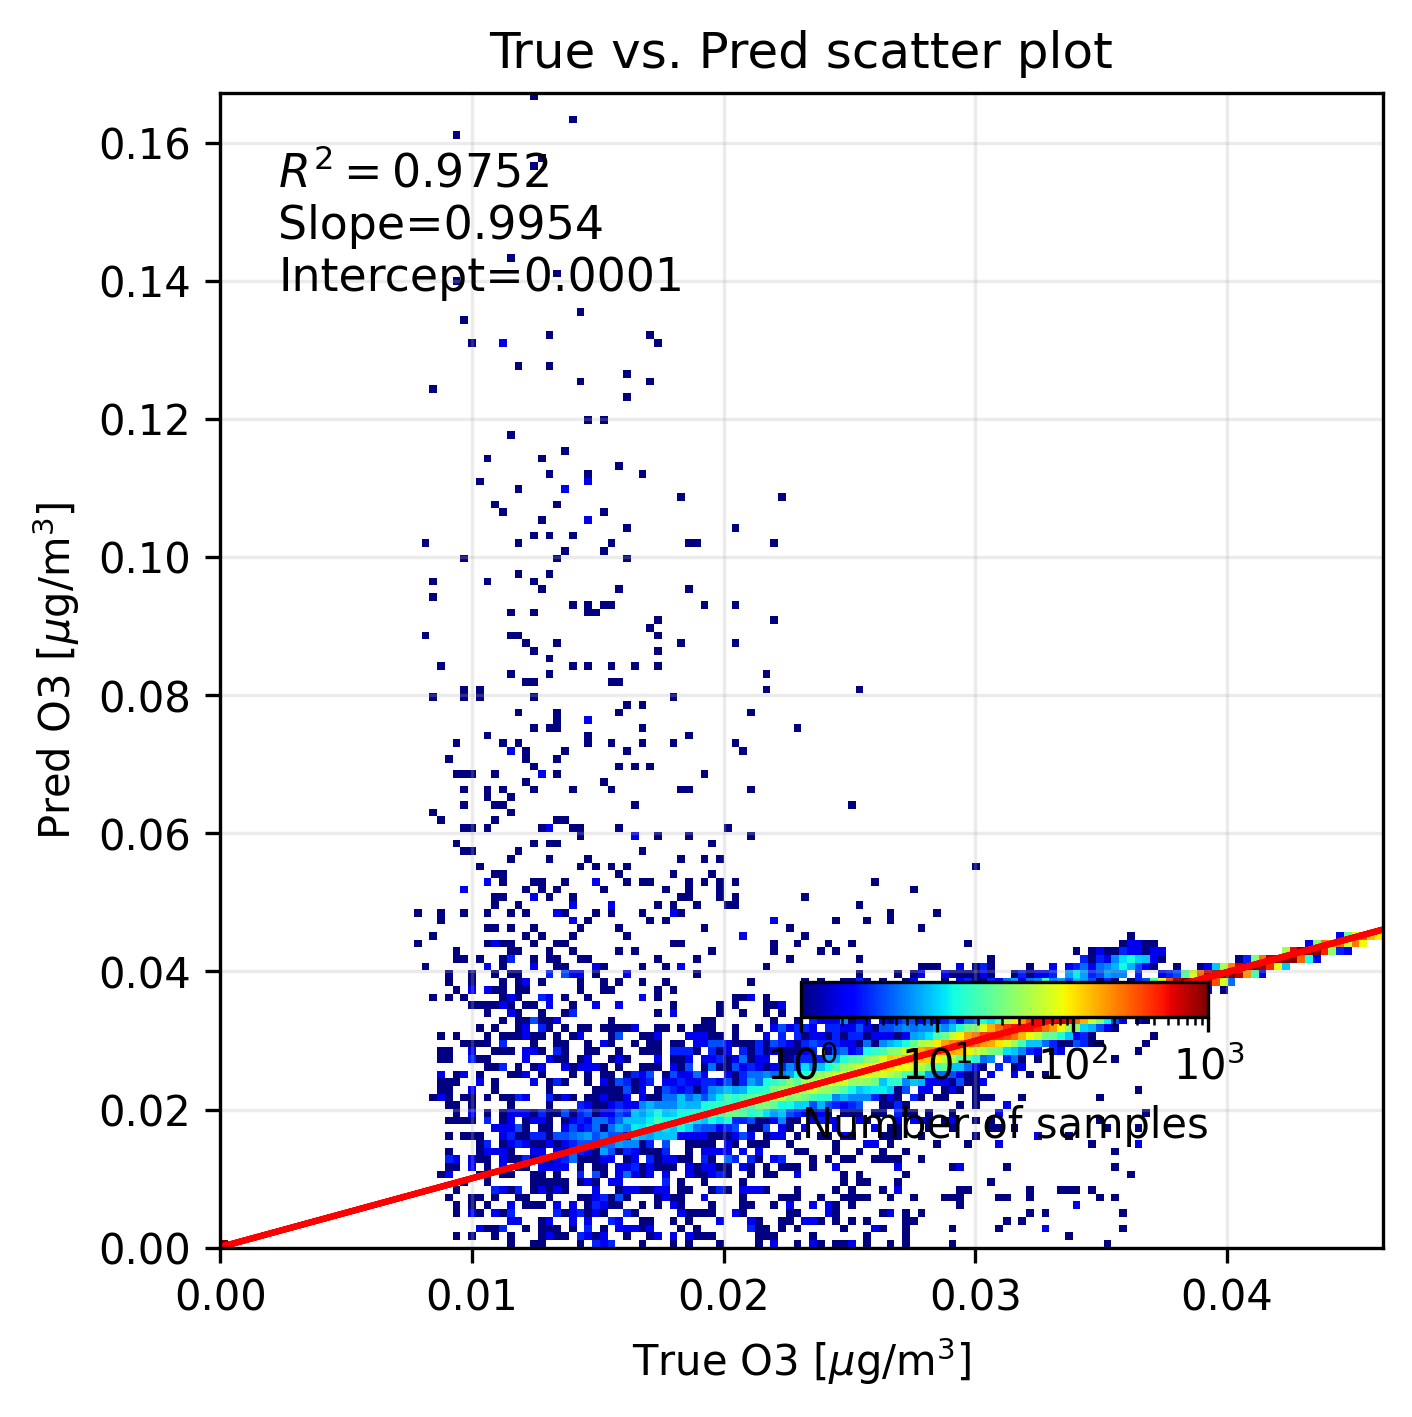

In [10]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

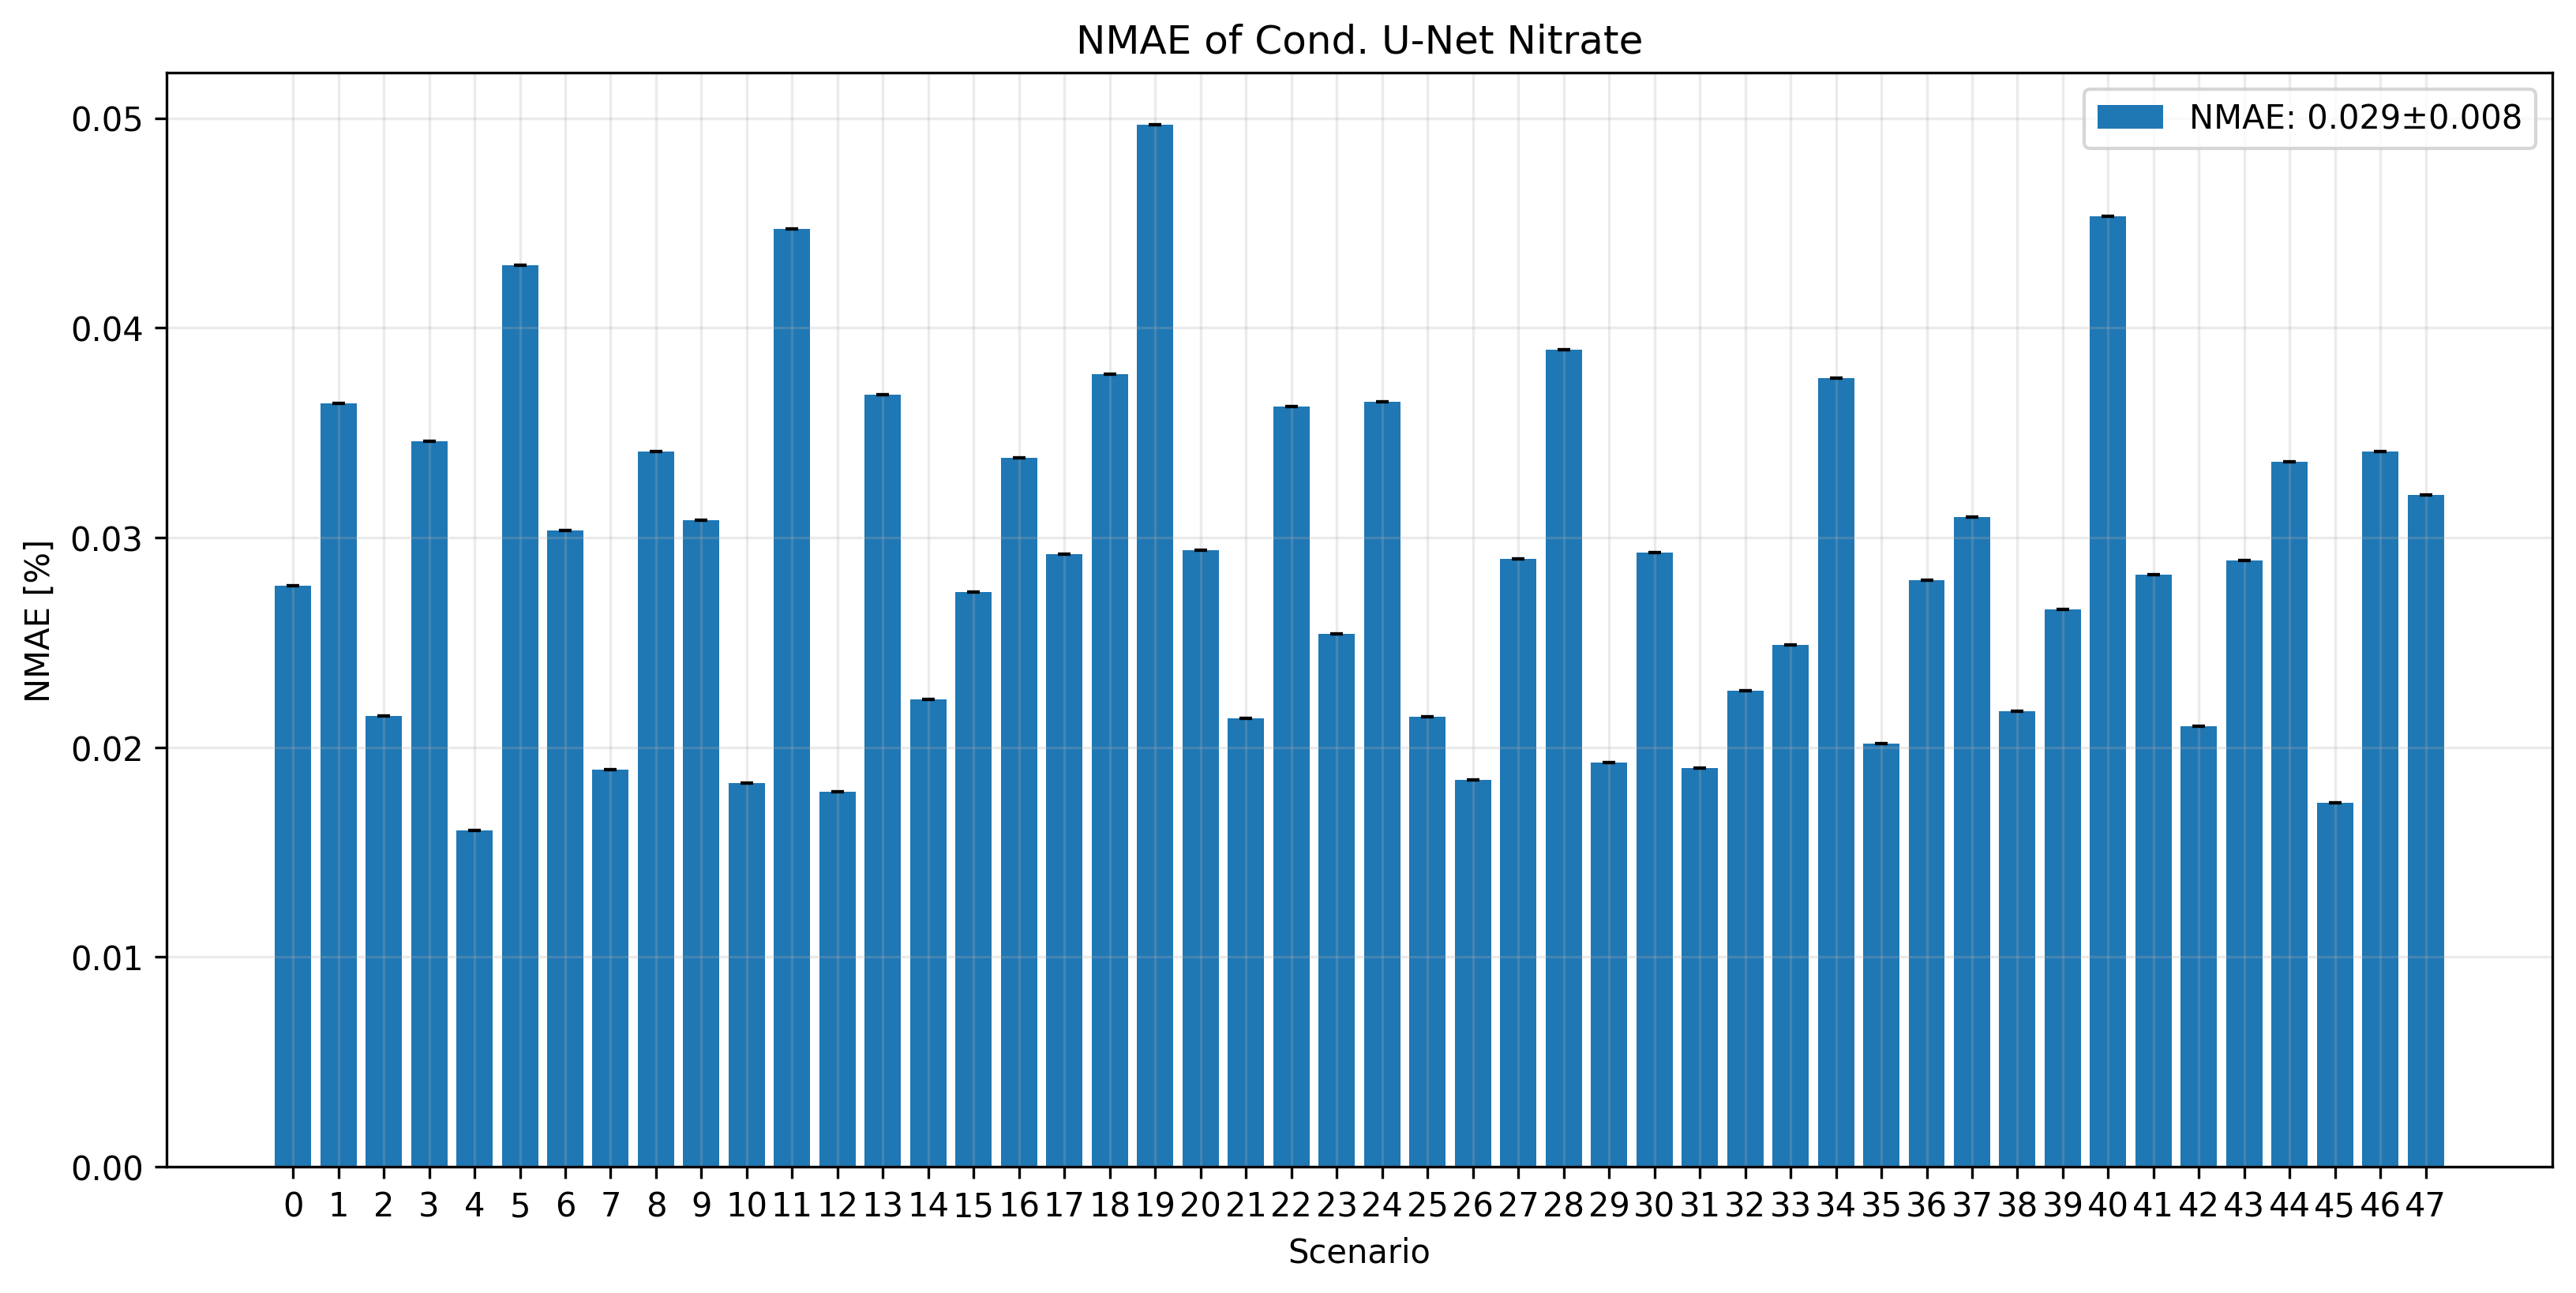

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

In [12]:
# np.set_printoptions(threshold=sys.maxsize)
# print(true_conc_map_w_lines[17])

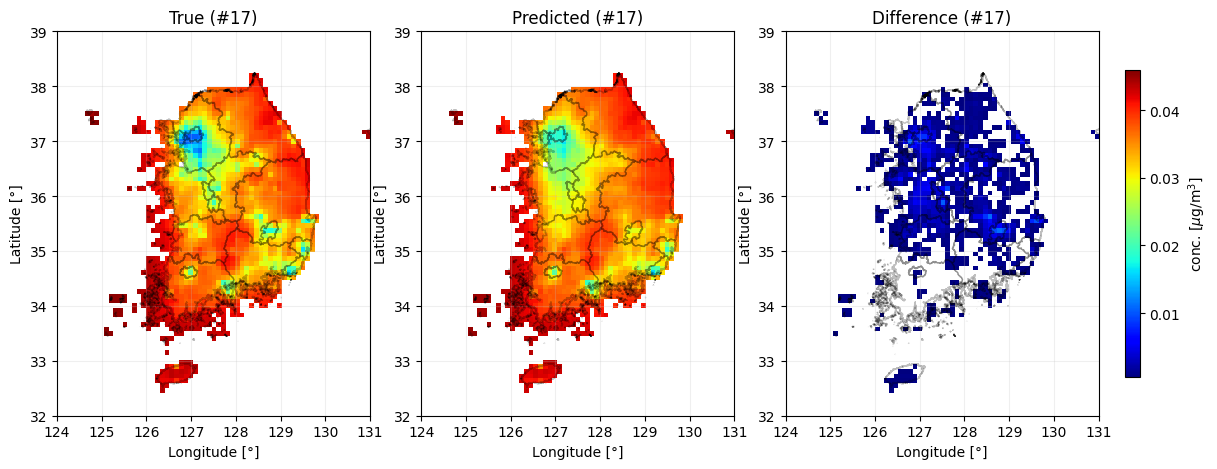

In [13]:
cmap_with_white = plt.get_cmap('jet').copy()   # 예: jet 컬러맵 복사
cmap_with_white.set_bad('white')               # 마스킹된 부분을 흰색으로

def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = [index]
    
    # (예시) "선택된 인덱스들"만 고려한 local_min/local_max
    local_min = min(y_true[indices].min(), y_pred[indices].min())
    local_max = max(y_true[indices].max(), y_pred[indices].max())
    local_diff = np.abs(y_true[indices] - y_pred[indices])
    local_max = max(local_max, local_diff.max())

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes[np.newaxis, :]  # (1, 3) 형태로 맞춤

    # 지도 투영 좌표 범위
    x_min = -180000 + offset_x
    x_max =  414000 + offset_x
    y_min = -585000 + offset_y
    y_max =  144000 + offset_y

    x_ticks = np.linspace(x_min, x_max, 8)
    x_labels = [str(i) for i in range(124, 132)]
    y_ticks = np.linspace(y_min, y_max, 8)
    y_labels = [str(i) for i in range(32, 40)]

    # "0 이하이면 흰색"으로 표시하고 싶다면:
    threshold = 0.0005  # 또는 원하는 임계값(예: local_min 등)

    for i, idx in enumerate(indices):
        # (A) True 데이터
        data_true = y_true[idx][::-1]
        # 2) 마스킹: threshold 이하 부분을 마스크
        masked_true = np.ma.masked_where(data_true <= threshold, data_true)
        
        im_true = axes[i, 0].imshow(
            masked_true,
            cmap=cmap_with_white,          # 마스킹 컬러맵
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,                # 컬러 스케일 최소
            vmax=local_max                 # 컬러 스케일 최대
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_xlim(x_min, x_max)
        axes[i, 0].set_ylim(y_min, y_max)
        axes[i, 0].set_xticks(x_ticks)
        axes[i, 0].set_yticks(y_ticks)
        axes[i, 0].set_xticklabels(x_labels)
        axes[i, 0].set_yticklabels(y_labels)
        axes[i, 0].grid(alpha=0.25, color='silver')

        # (B) Predicted
        data_pred = y_pred[idx][::-1]
        masked_pred = np.ma.masked_where(data_pred <= threshold, data_pred)

        im_pred = axes[i, 1].imshow(
            masked_pred,
            cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,
            vmax=local_max
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_xlim(x_min, x_max)
        axes[i, 1].set_ylim(y_min, y_max)
        axes[i, 1].set_xticks(x_ticks)
        axes[i, 1].set_yticks(y_ticks)
        axes[i, 1].set_xticklabels(x_labels)
        axes[i, 1].set_yticklabels(y_labels)
        axes[i, 1].grid(alpha=0.25, color='silver')

        # (C) Difference
        data_diff = np.abs(y_true[idx] - y_pred[idx])[::-1]
        masked_diff = np.ma.masked_where(data_diff <= threshold, data_diff)

        im_diff = axes[i, 2].imshow(
            masked_diff,
            cmap=cmap_with_white,
            extent=(x_min, x_max, y_min, y_max),
            vmin=threshold,
            vmax=local_max
        )
        ctprvn_proj.boundary.plot(
            ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25
        )
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_xlim(x_min, x_max)
        axes[i, 2].set_ylim(y_min, y_max)
        axes[i, 2].set_xticks(x_ticks)
        axes[i, 2].set_yticks(y_ticks)
        axes[i, 2].set_xticklabels(x_labels)
        axes[i, 2].set_yticklabels(y_labels)
        axes[i, 2].grid(alpha=0.25, color='silver')

    # 서브플롯 간격/레이아웃 조정
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.tight_layout(rect=[0, 0, 0.88, 0.96])

    # (3) 단일 컬러바
    cbar = fig.colorbar(
        im_true,
        ax=axes.ravel().tolist(),
        orientation='vertical',
        fraction=0.03,
        pad=0.02,
        shrink=0.8
    )
    cbar.set_label('conc. [$\\mu \\mathrm{g}/\\mathrm{m}^3$]')

    plt.show()

# ==============================
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=17)

In [14]:
true_conc_map_w_lines_re = true_conc_map_w_lines
pred_conc_map_w_lines_re = pred_conc_map_w_lines

true_conc_map_w_lines_re = np.delete(true_conc_map_w_lines, 17, axis=0)
pred_conc_map_w_lines_re = np.delete(pred_conc_map_w_lines, 17, axis=0)

print(true_conc_map_w_lines_re.shape)
print(pred_conc_map_w_lines_re.shape)

(47, 82, 67)
(47, 82, 67)


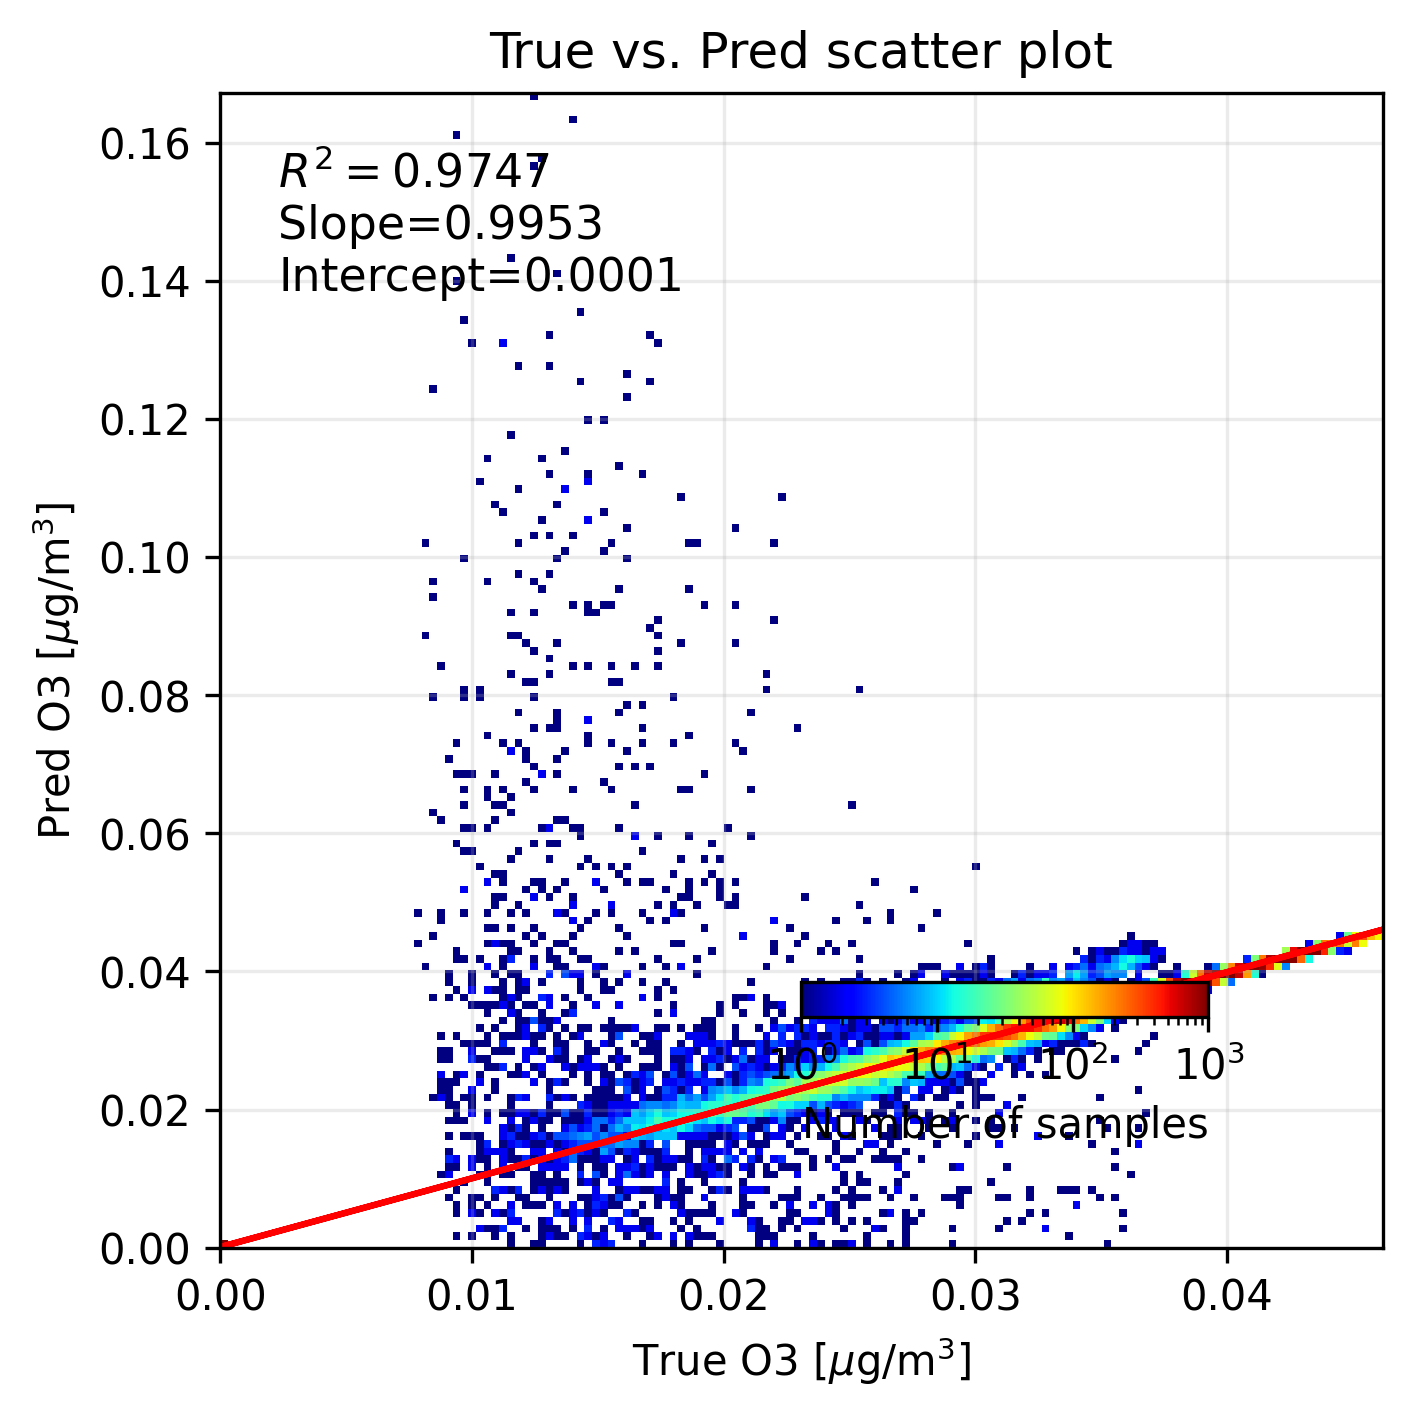

In [15]:
y_true_modi = true_conc_map_w_lines_re.reshape(-1)
y_pred_modi = pred_conc_map_w_lines_re.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred O3 [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

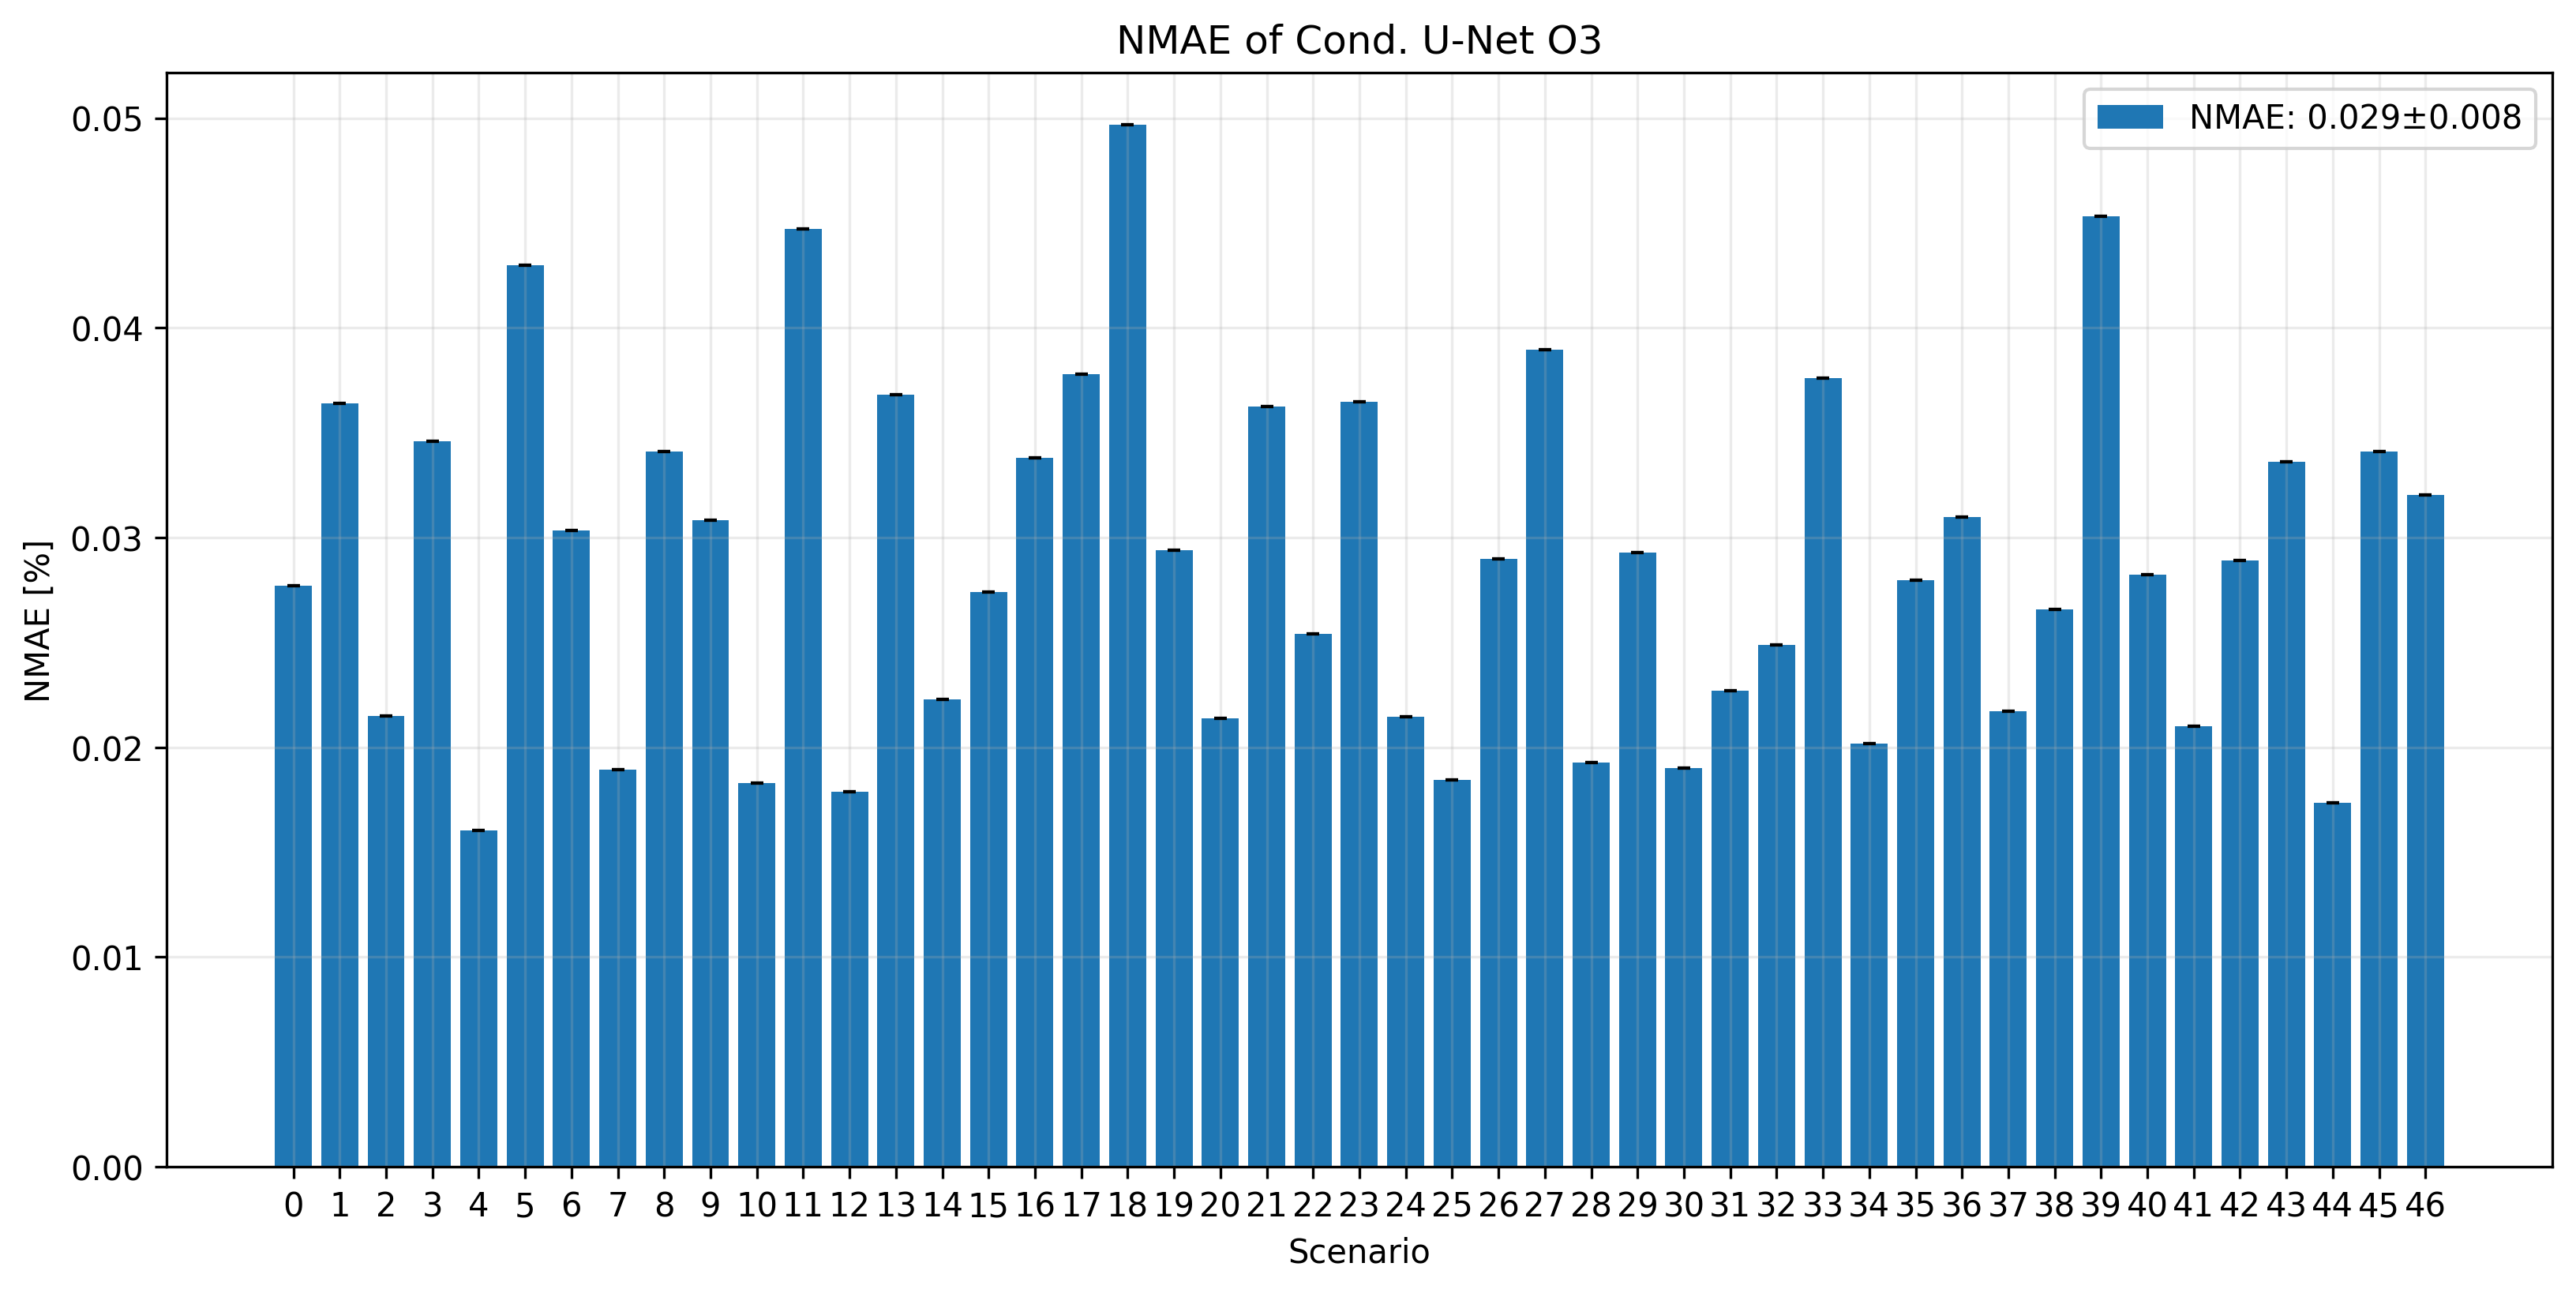

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines_re, pred_conc_map_w_lines_re)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]-1), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]-1), range(y_test.shape[0]-1))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net O3")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()